# Monte Carlo Methods and Metropolis-Hastings

## Some history of the Monte Carlo method

The idea of Monte Carlo calculation is a lot older than the computer. Under the older name of “statistical sampling” the method has a history stretching back well into the last century, when numerical calculations were performed by hand using pencil and paper and perhaps a slide-rule.

The name “Monte Carlo” is relatively recent: it was coined by Nicolas Metropolis in 1949 in a paper with Stanislav Ulam


![title](../Slides/Lecture6/MonteCarlo.png)

Nicholas Constantine Metropolis was born in 1915, in Chicago (where all the coolest people were born). In 1936 he received his bachelor’s degree, and in 1941, his doctorate, both from UChicago, and both in experimental physics. While here, Metropolis worked at the Met Lab as an assistant to Fermi. 

The MANIAC was Metropolis’ computer at Los Alamos: “Mathematical Analyzer, Numerical Integrator, and Computer”. In 1957, Metropolis returned to UChicago and founded the Institute for Computer Research. Here, he oversaw the construction MANIACIII machine.

## Simple Accept-Reject "Monte Carlo"

Part of the broad class of "Monte Carlo" type algorithms. 

The "accept-reject" method works as follows (from [Wikipedia](https://en.wikipedia.org/wiki/Rejection_sampling)):

 * Sample a point on the x-axis from the proposal distribution.
 * Draw a vertical line at this x-position, up to the curve of the proposal distribution.
 * Sample uniformly along this line from 0 to the maximum of the probability density function. 
   * If the sampled value is greater than the value of the desired distribution at this vertical line, reject the x-value and return to step 1; 
   * else the x-value is a sample from the desired distribution.
   
This algorithm can be used to sample from the area under any curve, regardless of whether the function integrates to 1. In fact, scaling a function by a constant has no effect on the sampled x-positions. Thus, the algorithm can be used to sample from a distribution whose normalizing constant is unknown, which is common in computational statistics. 

### Simple functional form

Start out with the usual libraries, except we'll also want the `norm` function explicitly available.

In [1]:
# Import the required modules
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Import the `norm` function from the scientific python (`scipy`) `stats` library
from scipy.stats import norm


Set some basic parameters for the functional form.

In [3]:
xmin = -10
xmax = 20
pmax = 0.8

Define a function form. I put two in here. One is a sin + double exponential. The other is a double Gaussian.

Note, that I've used the `norm` function that we imported above to get a normal continuous random variable:
* [scipy.stats.norm](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html)

The probability density function for norm is:

$$f(x) = \frac{1}{\sqrt{2\pi}}\exp(-x^2/2)$$

for a real number.

The probability density above is defined in the “standardized” form. To shift and/or scale the distribution use the `loc` and `scale` parameters. Specifically, `norm.pdf(x, loc, scale)` is identically equivalent to `norm.pdf(y) / scale` with `y = (x - loc) / scale`.


In [4]:
#this is an example distribution, feel free to change it
def p(x):
    #return np.sin(x-0.5)**2 * np.exp(-x**2) + .2*np.exp(-x**2)  #note, this one is not normalized pdf
    return (norm(7, 1).pdf(x) + norm(1, 2).pdf(x))/2

Plot the functional form

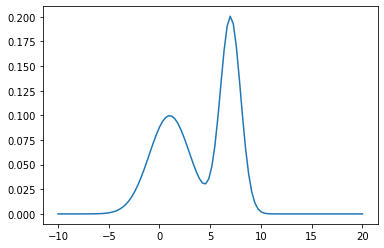

In [5]:
#let's plot it
x = np.linspace(-10,20,100)
y = p(x)
plt.plot(x,y)

### Naive python accept / reject

This is meant to be an easily readable implementation of the accept / reject algorithm.
It's easy to understand not very fast. It's the same as what we discussed on Tuesday.

In [6]:
def accept_reject(N):
    n_accept=0
    x_list = [] 
    while n_accept < N:
        t = (xmax-xmin)*np.random.rand() + xmin
        y = np.random.rand()
        if y < p(t)/ pmax:
            n_accept += 1
            x_list.append(t)
    return x_list

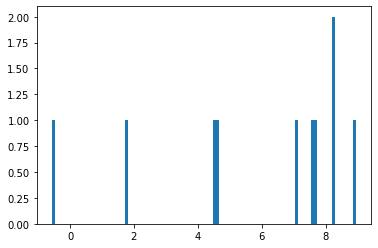

In [8]:
x = accept_reject(10)
bins, edges, patches = plt.hist(x, bins=100)
plt.show()

### "Efficient" accept-reject method

Now, we will implement the same "algorithm" but in a different way. This will make use of some internal methods from `numpy` that will let us populate the plane of values, and then quickly mask out the areas that should not be "accepted". 

In [30]:
N_MC = 1000

t = np.random.uniform(xmin,xmax,N_MC)  #get uniform temporary x values
y = np.random.uniform(0,pmax,N_MC)  # get uniform random y values

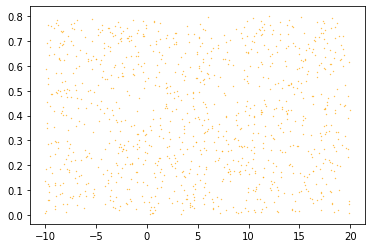

In [31]:
# plot all the t-y pairs
plt.scatter(t,y, s=0.1, c='orange')

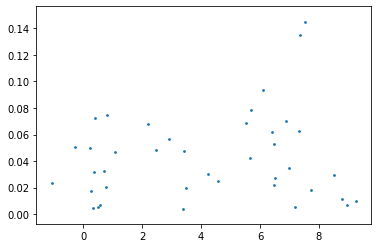

In [32]:
#make a mask that keeps index to the accepted pairs. Plot them
mask = y<p(t)
plt.scatter(t[mask],y[mask], s=3)

In [33]:
#inspect the mask
mask

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True, False, False, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False, False, False, False,  True, False, False, False,
       False, False,

In [34]:
#inspect the 0th entry
t[0], y[0], p(t[0]), mask[0]

(-1.521043760763554, 0.14538621942418928, 0.045063142782924906, False)

In [35]:
#How many t's are there beore / after the mask
t.size, t[mask].size

(1000, 40)

In [36]:
accept_prob = t[mask].size/t.size
print(accept_prob)

0.04


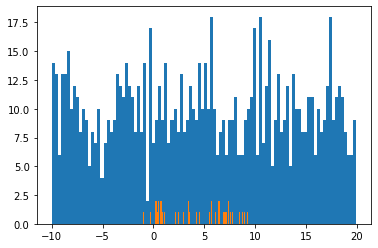

In [37]:
#histogram the t values with and without the mask
_ = plt.hist(t, bins=100)
_ = plt.hist(t[mask], bins=100)

## compare speed of the two approaches

In [38]:
%%timeit 
t = np.random.uniform(xmin,xmax,N_MC)  #get uniform temporary x values
y = np.random.uniform(0,pmax,N_MC)  # get uniform random y values
mask = y<p(t)

1.69 ms ± 8.16 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [39]:
%%timeit
#for a fair comparison, we will ask accept_reject to return the same number
average_accept = N_MC*accept_prob
x = accept_reject(average_accept)

1.56 s ± 161 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [23]:
#How much faster?
564/5.56

101.43884892086332

## Metropolis-Hastings

This relies on being able only to find a function $f(x)$ that is proportional to the desired probability distribution $P ( x )$.

* Choose initial configuration:
   * We need a probability density $g(x|y)$ that generates a value for the next sample value $x$ given the previous sample value $y$
   * For the Metropolis variant of the Metropolis-Hastings algorithm, $g$ must be symmetric
   * A usual choice is to let $g ( x | y )$ be a Gaussian distribution centered at $y$, so that points closer to $y$ are more likely to be visited next
   * This yields a sequence of samples that resembles *a random walk*
   * The function $g$ is referred to as the _proposal density_, or _jumping distribution_, or _selection probability_
* Loop over all desired values $t$ (or points in a lattice, for example!):
   * generate a candidate $x'$ for the next sample by picking from the distribution $g ( x' | x_t )$ 
   * calculate the acceptance ratio $\alpha =f(x')/f(x_{t})$, which will be used to decide whether to accept or reject the candidate
      * Because $f$ is proportional to the density of $P$, we have that $\alpha =f(x')/f(x_{t})=P(x')/P(x_{t})$ 
   
In the case of the Ising model, for a lattice of spins, these last three points are, more explicitly: 
   * Trial flip ($+1 \rightarrow -1$ or vice versa)
   * Compute change in energy
   * If $\delta = e^{- \Delta E/k_B T} > r$ (where $r$ is a uniform deviate) flip the spin 


Let's sample a random distribution and plot the histogram of the samples

Expected Value of x  = 4.018736568464987 with variance = 11.400298124376523


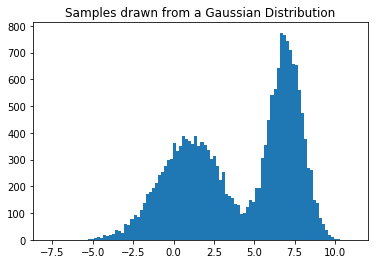

In [24]:
x = np.hstack((np.random.normal(7, 1, 10000), np.random.normal(1, 2, 10000)))
print('Expected Value of x  = {} with variance = {}'.format(np.mean(x), np.var(x)))
plt.hist(x, bins=100)
plt.title('Samples drawn from a Gaussian Distribution')
plt.show()

Now let's compare to the Metropolis-Hastings method. 

First set a few initial values:

In [25]:
# Initialize x_0
x = 5

# Number of samples
N = 1000

# Use a wide Gaussian distribution for `g` to sample from for the initial values
sigma = 100

# List of sampled points
x_sampled = []

In [26]:
for i in range(N-1):
    # Sample `x_star` from a gaussian distribution centered around `x`
    x_star = norm(x, sigma).rvs()
    # `u` lies in [0, 1]
    u = np.random.uniform()
    if u < min(1, (p(x_star)*norm(x_star, sigma).pdf(x))/(p(x)*norm(x, sigma).pdf(x_star))):
        x = x_star
    x_sampled.append(x)

Expected Value of x  = 3.7503529917220906 with variance = 12.242673793050457


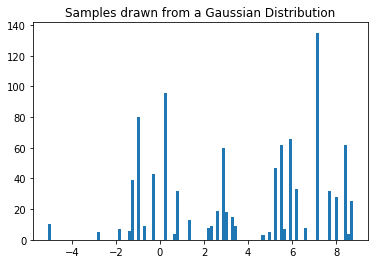

In [27]:
# Plot the sampled distribution
print('Expected Value of x  = {} with variance = {}'.format(np.mean(x_sampled), np.var(x_sampled)))
plt.hist(x_sampled, bins=100)
plt.title('Samples drawn from a Gaussian Distribution')
plt.show()